# Tuning Elo Rankings

This notebook aims to find the best parameters to plug into the Elo model. It makes heavy use of the `elo.py` module which is greatly inspired by the work from this [Kaggle kernel](https://www.kaggle.com/lpkirwin/fivethirtyeight-elo-ratings) which draws inspiration from how [fivethirtyeight](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/) calculates Elo rankings. For more information on the concepts behind the Elo ranking, here is the [Wikipedia](https://en.wikipedia.org/wiki/Elo_rating_system) article on it.

## Goal: Choose a baseline linear regression model


### Outline:
1. Examine default parameters of K = 20, HCA = 100
2. Calculate different end-of-the-regular-season Elo ratings with varying K and HCA parameters using regular season data.
3. Using X = Elo ratings and y = actual margin of victory, train a linear regression from data from the 2003-2016 tournaments and test on the 2017-2018 tournaments.
4. Calculate Mean Squared Errors and R^2 from each result.
5. The baseline model for this project is the linear regression model that minimizes Mean Squared Error and maximizes R^2 where X = Elo ratings calculated from the best parameters and y = margin of victory.




In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn import linear_model as lm
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import itertools
cwd = os.getcwd()
# Add directories for modules and data files
dirs = [x[0] for x in os.walk(cwd)]
[sys.path.append(d) for d in dirs]
data_dir = cwd+'\\Input\\DataFiles\\' # Manual way; TODO: find a relative way to do this automatically
vegas_dir = cwd+'\\Input\\VegasOdds\\'
elo_out_dir = cwd+'\\Output\\TestElos\\'
import elo

In [2]:
p = Path('.')
paths = list(p.glob('**/*.csv'))
paths

[WindowsPath('merged.csv'),
 WindowsPath('odds_2017_basic.csv'),
 WindowsPath('Input/DataFiles/Cities.csv'),
 WindowsPath('Input/DataFiles/ConferenceTourneyGames.csv'),
 WindowsPath('Input/DataFiles/EloHistory.csv'),
 WindowsPath('Input/DataFiles/GameCities.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyDetailedResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySeeds.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySlots.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonCompactResults.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonDetailedResults.csv'),
 WindowsPath('Input/DataFiles/SeasonElos.csv'),
 WindowsPath('Input/DataFiles/SeasonElosK25.csv'),
 WindowsPath('Input/DataFiles/Seasons.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyTeams.csv'),
 WindowsPath('Input/DataFiles/TeamCoaches.csv'),
 WindowsPath('Input/DataFiles/Teams.csv'),
 Windo

In [3]:
### Load Regular Season Results
# Start at 2003 because advanced stats can only be calculated that far back

start = 2003
rs_c = pd.read_csv(data_dir+'RegularSeasonCompactResults.csv')
rs_c = rs_c.loc[rs_c.Season>=start]
rs_c = rs_c.drop(['NumOT'], axis=1)
rs_c = rs_c.reset_index(drop=True)
rs_c.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc
82036,2018,132,1153,56,1222,55,N
82037,2018,132,1172,58,1348,57,N
82038,2018,132,1209,74,1426,61,N
82039,2018,132,1246,77,1397,72,N
82040,2018,132,1335,68,1217,65,N


In [4]:
rs_c.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc
0,2003,10,1104,68,1328,62,N
1,2003,10,1272,70,1393,63,N
2,2003,11,1266,73,1437,61,N
3,2003,11,1296,56,1457,50,N
4,2003,11,1400,77,1208,71,N


In [5]:
### Load Tournament Results
tourney_cr = pd.read_csv(data_dir+'NCAATourneyCompactResults.csv')
tourney_cr.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_cr = tourney_cr[tourney_cr.Season >= start]
tourney_cr['WMargin'] = tourney_cr.WScore - tourney_cr.LScore
tourney_cr = tourney_cr.reset_index(drop=True)
tourney_cr.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin
1043,2018,146,1437,71,1403,59,12
1044,2018,146,1242,85,1181,81,4
1045,2018,152,1276,69,1260,57,12
1046,2018,152,1437,95,1242,79,16
1047,2018,154,1437,79,1276,62,17


## Model Default: K = 20., HCA = 100.

FiveThirtyEight calculates their NBA Elo rankings using the default parameters K = 20 and Homecourt Advantage = 100. College basketball tends to be less deterministic than the NBA in general, so it's worth exploring what parameters work best.

The more frequent fluctuations are due to some key differences between the two leagues:

|                    |                                                                                                                                       NCAA                                                                                                                                      |                                                                                                                                                 NBA                                                                                                                                                 |
|--------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Amount of Games    | ~30-35 regular season games  + up to 5 sudden-death post-season games                                                                                                                                                                                                           | 82 regular season games  + 4 best of 7 post-season games                                                                                                                                                                                                                                            |
| Schedule Imbalance | First half consists of "Non-Conference" games against teams of highly varying talent.  Latter half contains "Conference" games  against teams among the same academic conference. These tend to be less variant than non-conference games but there are typically disparities.  | Each team faces opponents in its own division four times a year (16 games), plays six of the teams from the other two divisions in its conference four times (24 games), the remaining four teams three times (12 games),  and plays all the teams in the other conference twice apiece (30 games). |
| Talent Disparity   | There are 351 Division I NCAA Basketball programs, most of which are from small schools in the country.  The best recruits typically go to the best schools every year. Talent level is less imbalanced in the tournament.                                                      | There are 30 professional NBA teams consisting of the best basketball players in the world.                                                                                                                                                                                                         |
| Roster Turnover    | College players have 4 years of eligibility. College basketball programs have to recruit every year to fill open spots every year.                                                                                                                                              | NBA players stay in the league until they retire. NBA teams can keep their players until either party chooses to part ways.                                                                                                                                                                         |

Because NCAA basketball is more variant, and teams are more inconsistent, I suspect that the optimal K value is higher than the default 20 for the NBA. 

I also suspect that the optimal homecourt advantage is higher than the default 100 for a few hard-to-quantify / anecdotal reasons: 1. College players aren't used to traveling long distances, 2. The stronger, "Power Conference" programs (i.e. the ones with more resources) tend to play host more home games in the non-conference schedule portion than the smaller, typically weaker programs. This disparity in home games would amplify the effect of homecourt advantage.

In [6]:
# elos, preds = elo.season_elos(rs=rs_c) #For calculating Elos (Done first time)
elos = pd.read_csv(elo_out_dir+"SeasonElosK20HCA100.csv", index_col=0)

In [7]:
elos.head()

,Season,SeasonElo,TeamID
57902,2014,1408.066486,1101
62101,2015,1294.421941,1101
68675,2016,1210.101494,1101
72986,2017,1238.188633,1101
81712,2018,1293.608951,1101


In [8]:
elos.tail()

,Season,SeasonElo,TeamID
56457,2014,1455.254810,1464
61343,2015,1420.251640,1464
66937,2016,1361.696824,1464
72302,2017,1334.433914,1464
81686,2018,1255.501255,1464


In [9]:
elos_tourney = elo.winloss_features(df_teams=tourney_cr, df_feature=elos, feature_cols=['SeasonElo'])
elos_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
1043,2018,146,1437,71,1403,59,12,2090.449878,1834.376707,256.073171
1044,2018,146,1242,85,1181,81,4,1994.263058,2010.466879,-16.203821
1045,2018,152,1276,69,1260,57,12,1950.422401,1728.590543,221.831858
1046,2018,152,1437,95,1242,79,16,2090.449878,1994.263058,96.186820
1047,2018,154,1437,79,1276,62,17,2090.449878,1950.422401,140.027477


Text(0.5,1,'Margin of Victory vs. Elo Rating difference Across All Tournaments')

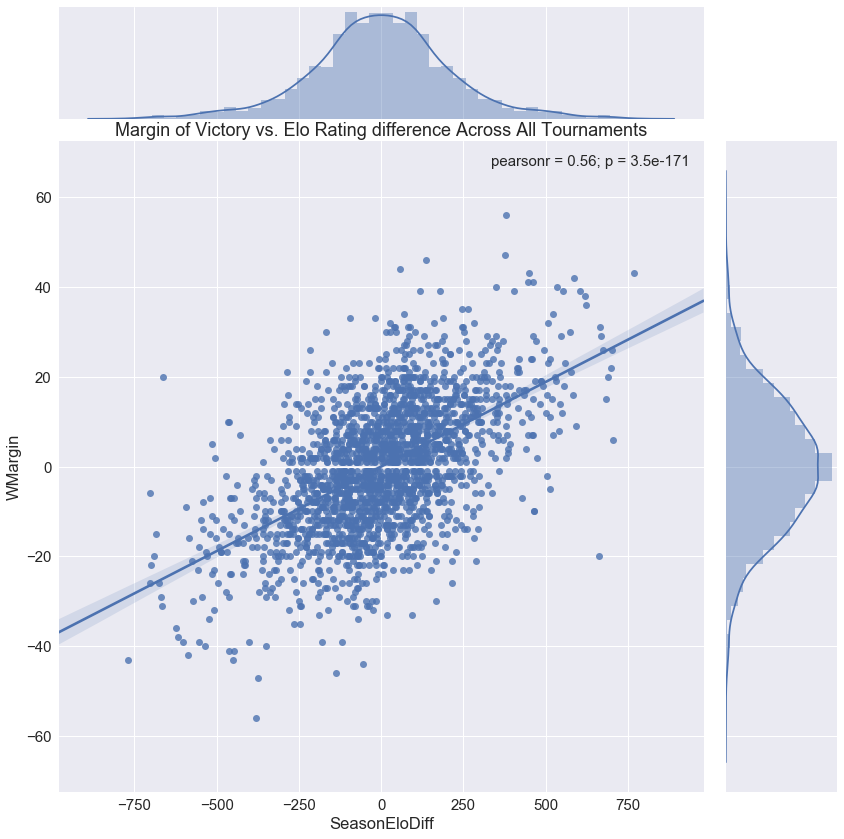

In [10]:
sns.set(font_scale=1.5)

elos_tourney = elo.mirror_df(elos_tourney, x='SeasonEloDiff', y='WMargin').reset_index(drop=True)

sns.jointplot(data=elos_tourney, x='SeasonEloDiff', y='WMargin', size=12, kind="reg")
plt.title("Margin of Victory vs. Elo Rating difference Across All Tournaments")

In [11]:
#elos_tourney = elo.mirror_df(elos_tourney, x='SeasonEloDiff', y='WMargin').reset_index(drop=True)


### Tuning Elo Ratings By K and HCA

In [12]:
def elo_tune(rs, tourney, Ks, HCAs, x_col='SeasonEloDiff', y_col='WMargin', season_cutoff=2017):
    params = list(itertools.product(Ks, HCAs))
    n_params = len(params)
    scores_all = []
    coefs = []
    for i in range(n_params):
        K, HCA = params[i]
        param_string = "K{}HCA{}".format(K,HCA)
        ### Calculate elos
        elos, rs_preds = elo.season_elos(rs, K, HCA)
        #elos.to_csv(elo_out_dir+"SeasonElos{}.csv".format(param_string))
        
        ### Preprocess elos into [[X][y], [-X],[-y]] form
        elos_tourney = elo.winloss_features(df_teams=tourney, df_feature=elos, feature_cols=['SeasonElo'])
        
        ### Mirror dfs
        elos_tourney = elo.mirror_df(elos_tourney, x=x_col, y=y_col).reset_index(drop=True)
        elos_tourney.to_csv(elo_out_dir+"EloTrain.csv".format(param_string))
        
        ### Evaluate
        scores, coef = elo_lr(elos_tourney, x_col, y_col)
        scores_all.append(scores)
        coefs.append(coef)
        
    return list(zip(params, scores_all)), list(zip(params, coefs))
        
def elo_lr(elos_tourney, x, y, season_cutoff=2017, metrics=[mean_squared_error, explained_variance_score]):
    lr = lm.LinearRegression()
    scores = []
    X_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, x].values.reshape(-1,1)
    X_train = StandardScaler().fit_transform(X_train)
    X_test = elos_tourney.loc[elos_tourney.Season>=season_cutoff, x].values.reshape(-1,1)
    X_test = StandardScaler().fit_transform(X_test)
    y_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, y].values.reshape(-1,1)
    y_train = StandardScaler().fit_transform(y_train)
    y_true = elos_tourney.loc[elos_tourney.Season>=season_cutoff, y].values.reshape(-1,1)
    y_true = StandardScaler().fit_transform(y_true)

    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    coef = lr.coef_
    
    for metric in metrics:
        scores.append(metric(y_true, y_pred))
        
    return scores, coef

In [13]:
### IMPORTANT: THIS CELL IS RESPONSIBLE FOR THE OUTPUT OF DIFFERENT ELO RATINGS.
### BECAUSE IT'S COMPUTATIONALLY EXPENSIVE TO RUN THIS CELL, IT'S ONLY RUN ONCE
### THE OUTPUT AND RESULTS IS IN "scores.npy"

Ks = np.arange(20, 81, 5)
HCAs = np.arange(100, 151, 10)
# scores, coefs = elo_tune(rs_c, tourney_cr, Ks, HCAs, season_cutoff=2017)
# np.save(elo_out_dir+"scores.npy",arr=np.array(scores))

In [14]:
### Compile metric scores, find parameters with the best scores
scores_arr = np.load(elo_out_dir+"scores.npy")
scores_dict = dict()
for arr in scores_arr:
    param, score = arr
    score = list(score)
    param = tuple(param.astype(int))
    
    scores_dict[param] = score

In [15]:
best_params = min(scores_dict, key=scores_dict.get)
print("The best parameters are K = {}, HCA = {} with MSE = {}, R^2 = {}".format(*best_params, *scores_dict[best_params]))

The best parameters are K = 65, HCA = 130 with MSE = 0.6486102183461235, R^2 = 0.35138978165387647


In [16]:
#mean_squared_errors = []
# from collections import Counter
# items = Counter(val[2] for val in dic.values())
mse_dict = dict()
for key,val in scores_dict.items():
    K, HCA = key
    mse, r2 = val
    if K in mse_dict.keys():
        mse_dict[K].append(mse)
    else:
        mse_dict[K] = [mse]

best_mse_per_k = [min(mse_dict[k]) for k in sorted(mse_dict)]

Text(0.5,1,'Mean Squared Error vs. K \nEvaluated on 2017-2018 Tournaments')

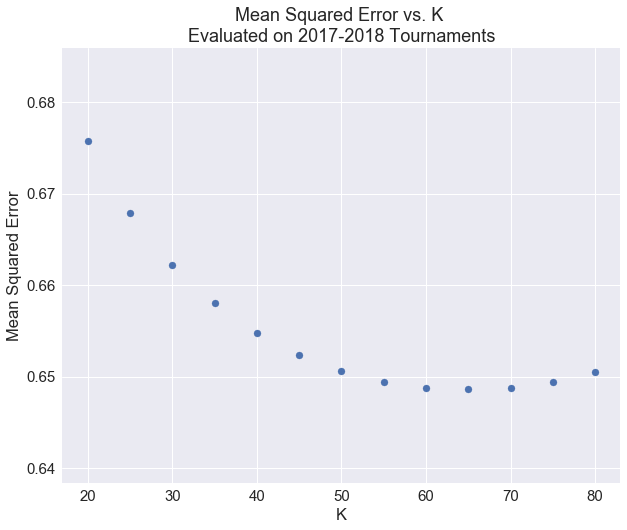

In [17]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,8))
plt.scatter(Ks, best_mse_per_k)
plt.xlabel('K')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. K \nEvaluated on 2017-2018 Tournaments')

### Tuning Results:

It was found that the optimal parameters for Elo ratings were K = 65., and Homecourt Advantage = 130. Thus, I'll use the Elo ratings which correspond to these parameters as the main features X. With y = the margin of victory, I'll retrain the model using the optimal Elo ratings. 

## Optimal Elo Parameters: K = 65, HCA = 130

In [18]:
#elos, preds = elo.season_elos(rs=rs_c, K=65., HOME_ADVANTAGE=130.) # For calculating the first time
#elos.to_csv(elo_out_dir+"SeasonElosK{}HCA{}.csv".format(*best_params))

elos = pd.read_csv(elo_out_dir+"SeasonElosK65HCA130.csv", index_col=0)
elos_tourney = elo.winloss_features(df_teams=tourney_cr, df_feature=elos, feature_cols=['SeasonElo'])
elos_tourney = elo.mirror_df(elos_tourney, x='SeasonEloDiff', y='WMargin').reset_index(drop=True)


In [19]:
elos_tourney_1718 = elos_tourney.loc[elos_tourney.Season >= 2017].reset_index(drop=True).sort_index()
#elos_tourney.to_csv(elo_out_dir+"EloTrainK{}HCA{}.csv".format(*best_params))
elos_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
2091,2018,146,1437,71,1403,59,-12,2188.106007,1973.857023,-214.248984
2092,2018,146,1242,85,1181,81,-4,2084.816709,2082.803818,-2.012891
2093,2018,152,1276,69,1260,57,-12,2153.645824,1890.909689,-262.736135
2094,2018,152,1437,95,1242,79,-16,2188.106007,2084.816709,-103.289298
2095,2018,154,1437,79,1276,62,-17,2188.106007,2153.645824,-34.460183


In [20]:
elos_tourney_1718.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 10 columns):
Season           268 non-null int64
DayNum           268 non-null int64
WTeamID          268 non-null int64
WScore           268 non-null int64
LTeamID          268 non-null int64
LScore           268 non-null int64
WMargin          268 non-null int64
WSeasonElo       268 non-null float64
LSeasonElo       268 non-null float64
SeasonEloDiff    268 non-null float64
dtypes: float64(3), int64(7)
memory usage: 21.0 KB


In [21]:
elos_tourney_1718.loc[elos_tourney_1718.Season==2018].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 67 to 267
Data columns (total 10 columns):
Season           134 non-null int64
DayNum           134 non-null int64
WTeamID          134 non-null int64
WScore           134 non-null int64
LTeamID          134 non-null int64
LScore           134 non-null int64
WMargin          134 non-null int64
WSeasonElo       134 non-null float64
LSeasonElo       134 non-null float64
SeasonEloDiff    134 non-null float64
dtypes: float64(3), int64(7)
memory usage: 11.5 KB


In [22]:
elos_tourney_1718.loc[elos_tourney_1718.Season==2017].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 200
Data columns (total 10 columns):
Season           134 non-null int64
DayNum           134 non-null int64
WTeamID          134 non-null int64
WScore           134 non-null int64
LTeamID          134 non-null int64
LScore           134 non-null int64
WMargin          134 non-null int64
WSeasonElo       134 non-null float64
LSeasonElo       134 non-null float64
SeasonEloDiff    134 non-null float64
dtypes: float64(3), int64(7)
memory usage: 11.5 KB


In [23]:
odds_tourney = pd.read_csv(cwd+"\\Output\\Odds\\tourneyodds_1718.csv", index_col=0)
odds_tourney = odds_tourney.sort_values(['date', 'WTeamID']).reset_index(drop=True).sort_index()
odds_tourney[['WTeamID', 'LTeamID', 'favoriteID', 'underdogID']] = odds_tourney[['WTeamID', 'LTeamID', 'favoriteID', 'underdogID']].astype(int)
#odds_tourney = pd.concat([odds_tourney, -odds_tourney])
odds_tourney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 32 columns):
LTeamID       134 non-null int32
WTeamID       134 non-null int32
date          134 non-null object
home          134 non-null object
homeID        134 non-null int64
hscore        134 non-null float64
line          134 non-null float64
lineavg       134 non-null float64
linedok       134 non-null float64
linedonc      134 non-null float64
lineespn      134 non-null float64
linefox       134 non-null float64
linemassey    134 non-null float64
linemoore     134 non-null float64
lineopen      134 non-null float64
linepugh      134 non-null float64
linesag       134 non-null float64
linesage      134 non-null float64
linesaggm     134 non-null float64
linesagp      134 non-null float64
margin        134 non-null float64
neutral       134 non-null float64
road          134 non-null object
roadID        134 non-null float64
rscore        134 non-null float64
std           134 non-null fl

Text(0.5,1,'Margin of Victory vs. Difference in Season Elos; K = 65, HCA = 130')

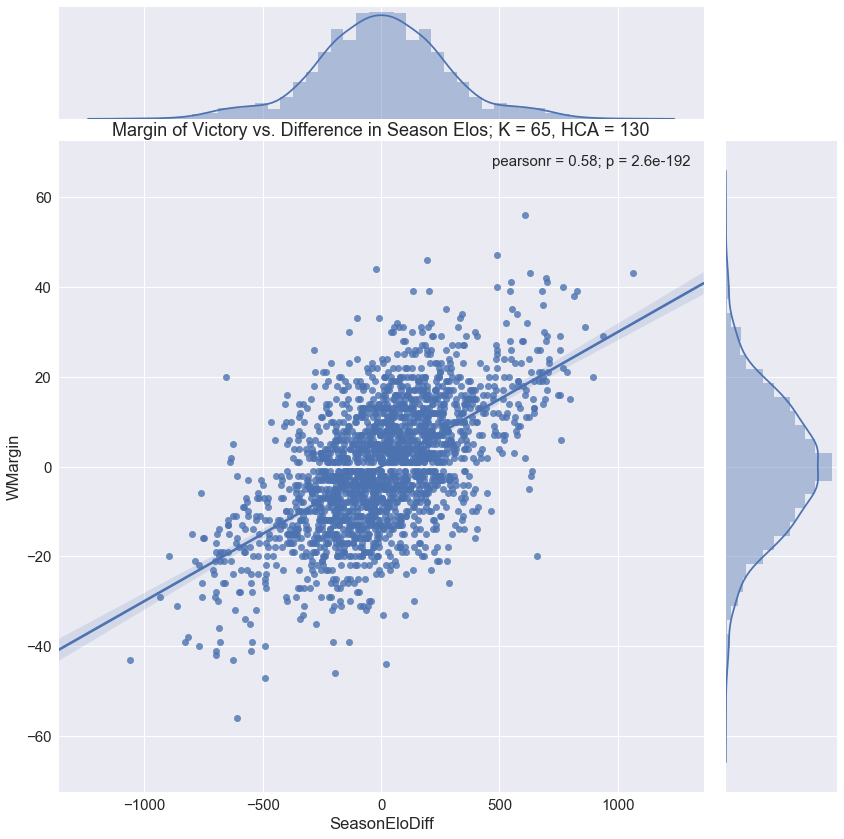

In [24]:
sns.set(font_scale=1.5)
sns.jointplot(data=elos_tourney, x='SeasonEloDiff', y='WMargin', size=12, kind="reg")
plt.title("Margin of Victory vs. Difference in Season Elos; K = {}, HCA = {}".format(*best_params))

In [25]:
elos_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
2091,2018,146,1437,71,1403,59,-12,2188.106007,1973.857023,-214.248984
2092,2018,146,1242,85,1181,81,-4,2084.816709,2082.803818,-2.012891
2093,2018,152,1276,69,1260,57,-12,2153.645824,1890.909689,-262.736135
2094,2018,152,1437,95,1242,79,-16,2188.106007,2084.816709,-103.289298
2095,2018,154,1437,79,1276,62,-17,2188.106007,2153.645824,-34.460183


In [26]:
def elo_predict(elos_tourney, x, y, season_cutoff=2017, metrics=[mean_squared_error, explained_variance_score]):
    lr = lm.LinearRegression()
    scores = []
    X_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, x].values.reshape(-1,1)
    #X_train = StandardScaler().fit_transform(X_train)
    X_test = elos_tourney.loc[elos_tourney.Season>=season_cutoff, x].values.reshape(-1,1)
    #X_test = StandardScaler().fit_transform(X_test)
    y_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, y].values.reshape(-1,1)
    #y_train = StandardScaler().fit_transform(y_train)
    y_true = elos_tourney.loc[elos_tourney.Season>=season_cutoff, y].values.reshape(-1,1)
    #y_true = StandardScaler().fit_transform(y_true)

    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    coef = lr.coef_
        
    return y_pred, coef

y_pred, coef= elo_predict(elos_tourney, x='SeasonEloDiff', y='WMargin')
elos_tourney_1718['PredMargin'] = y_pred.astype(int)

In [27]:
season_cutoff = 2017
x = 'SeasonEloDiff'
y = 'WMargin'
lr = lm.LinearRegression()
scores = []
X_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, x].values.reshape(-1,1)
#X_train = StandardScaler().fit_transform(X_train)
X_test = elos_tourney.loc[elos_tourney.Season>=season_cutoff, x].values.reshape(-1,1)
#X_test = StandardScaler().fit_transform(X_test)
y_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, y].values.reshape(-1,1)
#y_train = StandardScaler().fit_transform(y_train)
y_true = elos_tourney.loc[elos_tourney.Season>=season_cutoff, y].values.reshape(-1,1)
#y_true = StandardScaler().fit_transform(y_true)

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
coef = lr.coef_

Text(0.5,1,'Actual vs. Predicted Margin')

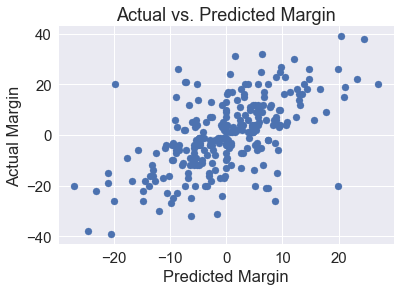

In [28]:
from scipy.stats import pearsonr
plt.scatter(y_pred, y_true)
plt.xlabel("Predicted Margin")
plt.ylabel("Actual Margin")
plt.title("Actual vs. Predicted Margin")
#plt.plot(y_pred*coef[0])
#plt.plot(X_test, y_pred)
#pearsonr(y_pred, y_true)

Text(0,0.5,'Actual Margin')

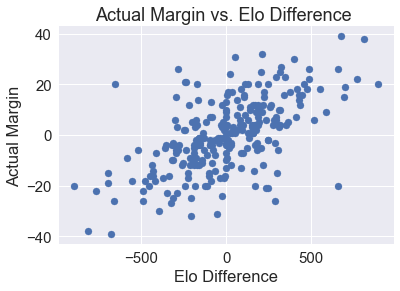

In [29]:
plt.title("Actual Margin vs. Elo Difference ")
plt.scatter(X_test, y_true)
plt.xlabel("Elo Difference")
plt.ylabel("Actual Margin")
#plt.plot(X_test*coef[0])

In [30]:
mean_squared_error(StandardScaler().fit_transform(X_train), StandardScaler().fit_transform(y_train))

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.83637977619859227

In [31]:
odds_tourney = pd.read_csv(cwd+"\\Output\\Odds\\tourneyodds_1718.csv", index_col=0)
odds_tourney = odds_tourney.sort_values(['date', 'WTeamID']).reset_index(drop=True).sort_index()
odds_tourney[['WTeamID', 'LTeamID']] = odds_tourney[['WTeamID', 'LTeamID']].astype(int)
odds_tourney.rename({'margin':'WMargin'}, axis=1, inplace=True)
odds_tourney.WMargin = odds_tourney.WMargin.astype(int)
line_cols = [col for col in odds_tourney if col.startswith('line')]
odds_tourney = elo.mirror_df(odds_tourney, line_cols, 'WMargin')
#odds_tourney = pd.concat([odds_tourney, -odds_tourney])
odds_tourney.tail()

,LTeamID,WTeamID,date,home,homeID,hscore,line,lineavg,linedok,linedonc,...,road,roadID,rscore,std,favwins,homewins,favoriteID,underdogID,WinATS,LoseATS
129,1181,1242,2018-03-25,Kansas,1242,85.0,3.5,2.80,3.95,2.7,...,Duke,1181.0,81.0,2.04,0,1,1181.0,1242.0,1,-1
130,1403,1437,2018-03-25,Villanova,1437,71.0,-6.5,-6.23,-5.87,-6.4,...,Texas Tech,1403.0,59.0,1.79,1,1,1437.0,1403.0,1,-1
131,1260,1276,2018-03-31,Michigan,1276,69.0,-5.5,-6.59,-5.95,-7.2,...,Loyola-Chicago,1260.0,57.0,2.38,1,1,1276.0,1260.0,1,-1
132,1242,1437,2018-03-31,Villanova,1437,95.0,-5.0,-4.60,-4.71,-4.4,...,Kansas,1242.0,79.0,1.34,1,1,1437.0,1242.0,1,-1
133,1276,1437,2018-04-02,Villanova,1437,79.0,-6.5,-4.79,-6.13,-5.1,...,Michigan,1276.0,62.0,3.30,1,1,1437.0,1276.0,1,-1


In [32]:
odds_tourney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 133
Data columns (total 32 columns):
LTeamID       268 non-null int32
WTeamID       268 non-null int32
date          268 non-null object
home          268 non-null object
homeID        268 non-null int64
hscore        268 non-null float64
line          268 non-null float64
lineavg       268 non-null float64
linedok       268 non-null float64
linedonc      268 non-null float64
lineespn      268 non-null float64
linefox       268 non-null float64
linemassey    268 non-null float64
linemoore     268 non-null float64
lineopen      268 non-null float64
linepugh      268 non-null float64
linesag       268 non-null float64
linesage      268 non-null float64
linesaggm     268 non-null float64
linesagp      268 non-null float64
WMargin       268 non-null int32
neutral       268 non-null float64
road          268 non-null object
roadID        268 non-null float64
rscore        268 non-null float64
std           268 non-null floa

In [33]:
elos_tourney_1718.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 11 columns):
Season           268 non-null int64
DayNum           268 non-null int64
WTeamID          268 non-null int64
WScore           268 non-null int64
LTeamID          268 non-null int64
LScore           268 non-null int64
WMargin          268 non-null int64
WSeasonElo       268 non-null float64
LSeasonElo       268 non-null float64
SeasonEloDiff    268 non-null float64
PredMargin       268 non-null int32
dtypes: float64(3), int32(1), int64(7)
memory usage: 22.1 KB


In [34]:
# def mirror_df(df, cols):
#     df_pos = df.copy()
#     df_pos[cols] = df[cols]    
#     df_neg = df.copy()
#     df_neg[cols] = -df[cols]

#     df_mirrored = pd.concat((df_pos, df_neg))
    
#     return df_mirrored
# line_cols = [col for col in odds_tourney if col.startswith('line')]
# line_cols + ['margin']
#odds_tourney = elo.mirror_df(odds_tourney, x='lineavg', y='margin')
#odds_tourney = pd.concat((odds_tourney, odds_tourney))

In [35]:
odds_tourney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 133
Data columns (total 32 columns):
LTeamID       268 non-null int32
WTeamID       268 non-null int32
date          268 non-null object
home          268 non-null object
homeID        268 non-null int64
hscore        268 non-null float64
line          268 non-null float64
lineavg       268 non-null float64
linedok       268 non-null float64
linedonc      268 non-null float64
lineespn      268 non-null float64
linefox       268 non-null float64
linemassey    268 non-null float64
linemoore     268 non-null float64
lineopen      268 non-null float64
linepugh      268 non-null float64
linesag       268 non-null float64
linesage      268 non-null float64
linesaggm     268 non-null float64
linesagp      268 non-null float64
WMargin       268 non-null int32
neutral       268 non-null float64
road          268 non-null object
roadID        268 non-null float64
rscore        268 non-null float64
std           268 non-null floa

In [36]:
elos_tourney_1718.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 11 columns):
Season           268 non-null int64
DayNum           268 non-null int64
WTeamID          268 non-null int64
WScore           268 non-null int64
LTeamID          268 non-null int64
LScore           268 non-null int64
WMargin          268 non-null int64
WSeasonElo       268 non-null float64
LSeasonElo       268 non-null float64
SeasonEloDiff    268 non-null float64
PredMargin       268 non-null int32
dtypes: float64(3), int32(1), int64(7)
memory usage: 22.1 KB


In [37]:
merged = pd.merge(elos_tourney_1718, odds_tourney, on=['WTeamID', 'LTeamID', 'WMargin']).drop_duplicates()
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 0 to 261
Data columns (total 40 columns):
Season           262 non-null int64
DayNum           262 non-null int64
WTeamID          262 non-null int64
WScore           262 non-null int64
LTeamID          262 non-null int64
LScore           262 non-null int64
WMargin          262 non-null int64
WSeasonElo       262 non-null float64
LSeasonElo       262 non-null float64
SeasonEloDiff    262 non-null float64
PredMargin       262 non-null int32
date             262 non-null object
home             262 non-null object
homeID           262 non-null int64
hscore           262 non-null float64
line             262 non-null float64
lineavg          262 non-null float64
linedok          262 non-null float64
linedonc         262 non-null float64
lineespn         262 non-null float64
linefox          262 non-null float64
linemassey       262 non-null float64
linemoore        262 non-null float64
lineopen         262 non-null float64
lin

In [38]:
merged

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff,...,road,roadID,rscore,std,favwins,homewins,favoriteID,underdogID,WinATS,LoseATS
0,2017,134,1243,95,1448,88,7,1817.590048,1628.452293,189.137755,...,Kansas St.,1243.0,95.0,1.68,0,0,1243.0,1448.0,-1,1
1,2017,134,1291,67,1309,66,1,1284.964660,1283.534840,1.429820,...,Mount St. Marys,1291.0,67.0,1.86,0,0,1291.0,1309.0,-1,1
2,2017,135,1413,67,1300,63,4,1386.152741,1389.581706,-3.428965,...,NC Central,1300.0,63.0,2.34,0,1,1300.0,1413.0,1,-1
3,2017,135,1425,75,1344,71,4,1895.976116,1901.924713,-5.948597,...,USC,1425.0,75.0,1.73,0,0,1425.0,1344.0,-1,1
4,2017,136,1112,100,1315,82,18,2021.058406,1466.304543,554.753863,...,North Dakota,1315.0,82.0,2.70,1,1,1112.0,1315.0,1,-1
5,2017,136,1139,76,1457,64,12,1992.591772,1555.655734,436.936038,...,Winthrop,1457.0,64.0,2.74,1,1,1139.0,1457.0,1,-1
6,2017,136,1196,80,1190,65,15,1914.316191,1689.871532,224.444659,...,East Tennessee St.,1190.0,65.0,2.63,1,1,1196.0,1190.0,1,-1
7,2017,136,1199,86,1195,80,6,1856.140575,1575.180770,280.959805,...,Florida Gulf Coast,1195.0,80.0,2.39,1,1,1199.0,1195.0,-1,1
8,2017,136,1211,66,1355,46,20,2084.516697,1627.195520,457.321177,...,South Dakota St.,1355.0,46.0,3.65,1,1,1211.0,1355.0,-1,1
9,2017,136,1235,84,1305,73,11,1908.172496,1715.559271,192.613225,...,Nevada,1305.0,73.0,2.00,1,1,1235.0,1305.0,1,-1


In [39]:
merged.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff,...,road,roadID,rscore,std,favwins,homewins,favoriteID,underdogID,WinATS,LoseATS
257,2018,146,1437,71,1403,59,-12,2188.106007,1973.857023,-214.248984,...,Texas Tech,1403.0,59.0,1.79,1,1,1437.0,1403.0,1,-1
258,2018,146,1242,85,1181,81,-4,2084.816709,2082.803818,-2.012891,...,Duke,1181.0,81.0,2.04,0,1,1181.0,1242.0,1,-1
259,2018,152,1276,69,1260,57,-12,2153.645824,1890.909689,-262.736135,...,Loyola-Chicago,1260.0,57.0,2.38,1,1,1276.0,1260.0,1,-1
260,2018,152,1437,95,1242,79,-16,2188.106007,2084.816709,-103.289298,...,Kansas,1242.0,79.0,1.34,1,1,1437.0,1242.0,1,-1
261,2018,154,1437,79,1276,62,-17,2188.106007,2153.645824,-34.460183,...,Michigan,1276.0,62.0,3.30,1,1,1437.0,1276.0,1,-1


In [40]:
merged[['WTeamID', 'LTeamID', 'WMargin', 'SeasonEloDiff', 'PredMargin', 'lineavg', 'home', 'road']]

,WTeamID,LTeamID,WMargin,SeasonEloDiff,PredMargin,lineavg,home,road
0,1243,1448,7,189.137755,5,-0.09,Wake Forest,Kansas St.
1,1291,1309,1,1.429820,0,-0.95,New Orleans,Mount St. Marys
2,1413,1300,4,-3.428965,0,-2.33,UC Davis,NC Central
3,1425,1344,4,-5.948597,0,-0.44,Providence,USC
4,1112,1315,18,554.753863,16,16.59,Arizona,North Dakota
5,1139,1457,12,436.936038,13,11.06,Butler,Winthrop
6,1196,1190,15,224.444659,6,11.39,Florida,East Tennessee St.
7,1199,1195,6,280.959805,8,12.48,Florida St.,Florida Gulf Coast
8,1211,1355,20,457.321177,13,23.39,Gonzaga,South Dakota St.
9,1235,1305,11,192.613225,5,6.44,Iowa St.,Nevada


In [41]:
1/coef

array([[ 33.1846113]])

Text(0.5,1,'Margin of Victory vs. Elo Difference')

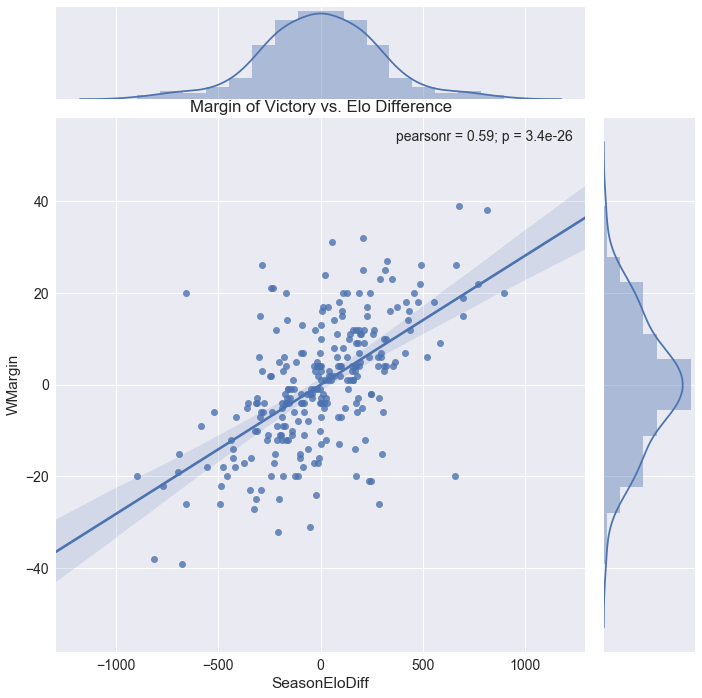

In [42]:
sns.set(font_scale=1.4)
sns.jointplot(data=merged, x='SeasonEloDiff', y='WMargin', size=10, kind="reg")
plt.title("Margin of Victory vs. Elo Difference")

Text(0.5,1,'Margin of Victory vs. Predicted Margin (By Elo Rating)')

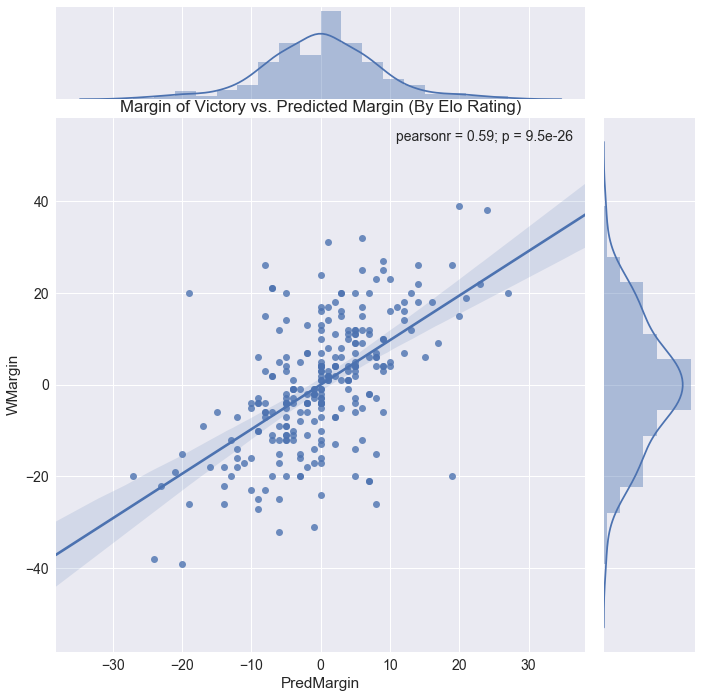

In [43]:
sns.jointplot(data=merged, x='PredMargin', y='WMargin', size=10, kind="reg")
plt.title("Margin of Victory vs. Predicted Margin (By Elo Rating)")

Text(0.5,1,'Margin of Victory vs. Average Betting Line')

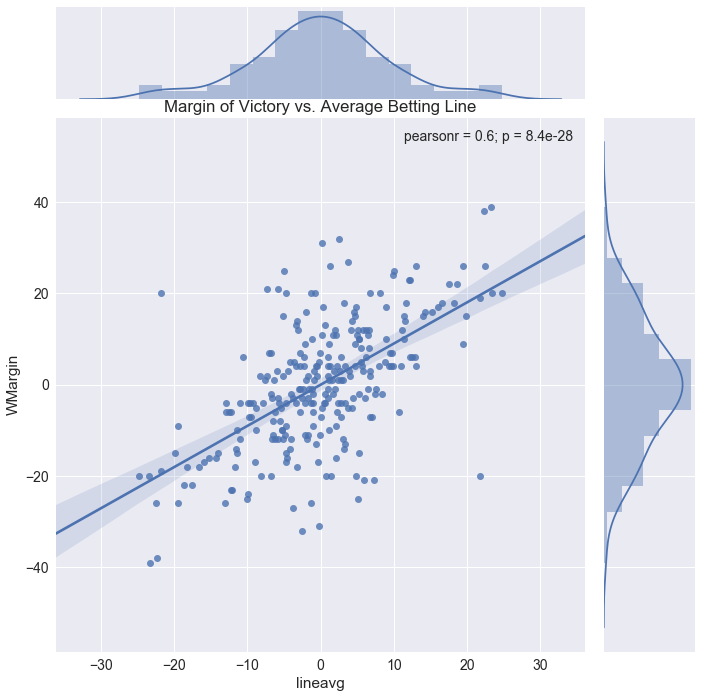

In [44]:
sns.jointplot(data=odds_tourney, x='lineavg', y='WMargin', size=10, kind="reg")
plt.title("Margin of Victory vs. Average Betting Line")


In [45]:
merged[['WMargin', 'PredMargin', 'lineavg']].head(15)

,WMargin,PredMargin,lineavg
0,7,5,-0.09
1,1,0,-0.95
2,4,0,-2.33
3,4,0,-0.44
4,18,16,16.59
5,12,13,11.06
6,15,6,11.39
7,6,8,12.48
8,20,13,23.39
9,11,5,6.44


In [46]:
number = 6.8
#round(6.7) - .5
round(number * 2) / 2
#(6.8 % 0.5)*6.8
6.8%0.5, 6.8/0.5

(0.2999999999999998, 13.6)

In [47]:
7.1//0.5, 7.1*2, 7.4//0.5, 7.4*2, 6.6//0.5, 6.6*2, 6.9//0.5, 6.9*2

(14.0, 14.2, 14.0, 14.8, 13.0, 13.2, 13.0, 13.8)

In [48]:
# def bet_cover(line, pred, actual):
#     if (actual > line) & (pred > line):
#         return 1
#     elif (actual > line) & (pred > line)

# merged['PredBet'] = (merged[['lineavg', 'PredMargin']]
#                                 .apply(lambda x: "Against" if x[1] >= x[0] else "Cover", axis=1)
#                                )

merged['PredBetWATS'] = (merged[['lineavg', 'PredMargin', 'WMargin']]
                                .apply(lambda x: 1 if ((x[1] < x[0]) & (x[2] < x[0])) else -1, axis=1)
                               )
merged['PredBetLATS'] = (merged[['lineavg', 'PredMargin', 'WMargin']]
                                .apply(lambda x: 1 if ((x[1] >= x[0]) & (x[2] >= x[0])) else -1, axis=1)
                               )

merged['PredBet'] = (merged[['lineavg', 'PredMargin', 'WMargin']]
                                .apply(lambda x: 1 if (((x[1] < x[0]) & (x[2] < x[0])) |
                                                      ((x[1] >= x[0]) & (x[2] >= x[0]))) else -1, axis=1)
                               )
merged['PredBetWATSrofit'] = merged['PredBetWATS'].cumsum()
merged['PredBetLATSProfit'] = merged['PredBetLATS'].cumsum()
merged['PredBetProfit'] = merged['PredBet'].cumsum()
# merged['PredBetFavorite'] = (merged[['WMargin', 'lineavg', 'PredMargin']]
#                                 .apply(lambda x: 1 if x[1] <= x[0] else -1, axis=1)
#                                )

merged.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff,...,favoriteID,underdogID,WinATS,LoseATS,PredBetWATS,PredBetLATS,PredBet,PredBetWATSrofit,PredBetLATSProfit,PredBetProfit
257,2018,146,1437,71,1403,59,-12,2188.106007,1973.857023,-214.248984,...,1437.0,1403.0,1,-1,-1,-1,-1,-118,-114,26
258,2018,146,1242,85,1181,81,-4,2084.816709,2082.803818,-2.012891,...,1181.0,1242.0,1,-1,1,-1,1,-117,-115,27
259,2018,152,1276,69,1260,57,-12,2153.645824,1890.909689,-262.736135,...,1276.0,1260.0,1,-1,1,-1,1,-116,-116,28
260,2018,152,1437,95,1242,79,-16,2188.106007,2084.816709,-103.289298,...,1437.0,1242.0,1,-1,-1,-1,-1,-117,-117,27
261,2018,154,1437,79,1276,62,-17,2188.106007,2153.645824,-34.460183,...,1437.0,1276.0,1,-1,-1,-1,-1,-118,-118,26


In [49]:
merged.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff,...,favoriteID,underdogID,WinATS,LoseATS,PredBetWATS,PredBetLATS,PredBet,PredBetWATSrofit,PredBetLATSProfit,PredBetProfit
0,2017,134,1243,95,1448,88,7,1817.590048,1628.452293,189.137755,...,1243.0,1448.0,-1,1,-1,1,1,-1,1,1
1,2017,134,1291,67,1309,66,1,1284.964660,1283.534840,1.429820,...,1291.0,1309.0,-1,1,-1,1,1,-2,2,2
2,2017,135,1413,67,1300,63,4,1386.152741,1389.581706,-3.428965,...,1300.0,1413.0,1,-1,-1,1,1,-3,3,3
3,2017,135,1425,75,1344,71,4,1895.976116,1901.924713,-5.948597,...,1425.0,1344.0,-1,1,-1,1,1,-4,4,4
4,2017,136,1112,100,1315,82,18,2021.058406,1466.304543,554.753863,...,1112.0,1315.0,1,-1,-1,-1,-1,-5,3,3


In [50]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 0 to 261
Data columns (total 46 columns):
Season               262 non-null int64
DayNum               262 non-null int64
WTeamID              262 non-null int64
WScore               262 non-null int64
LTeamID              262 non-null int64
LScore               262 non-null int64
WMargin              262 non-null int64
WSeasonElo           262 non-null float64
LSeasonElo           262 non-null float64
SeasonEloDiff        262 non-null float64
PredMargin           262 non-null int32
date                 262 non-null object
home                 262 non-null object
homeID               262 non-null int64
hscore               262 non-null float64
line                 262 non-null float64
lineavg              262 non-null float64
linedok              262 non-null float64
linedonc             262 non-null float64
lineespn             262 non-null float64
linefox              262 non-null float64
linemassey           262 non-null

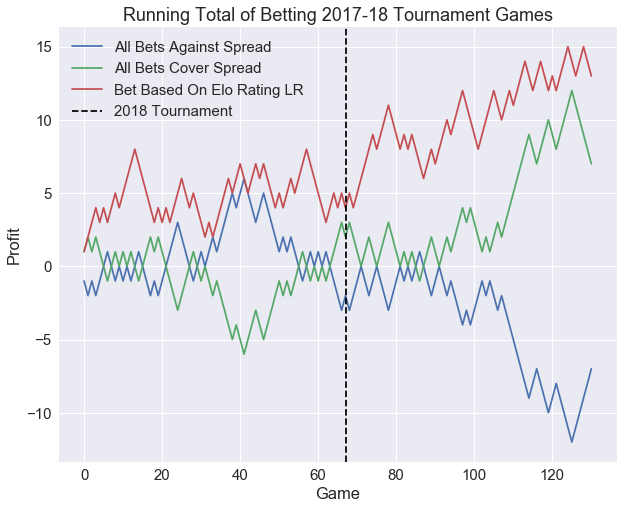

In [51]:
#x = np.arange(0,len(odds_2017.index.values))
sns.set(font_scale=1.5)
plt.figure(figsize=(10,8))
plt.title("Running Total of Betting 2017-18 Tournament Games")
x = np.arange(0,131)
win_ats = np.cumsum(merged['WinATS'][:131])
lose_ats = np.cumsum(merged['LoseATS'][:131])
either_bet = np.cumsum(merged['PredBet'][:131])

plt.xlabel("Game")
plt.ylabel("Profit")
plt.plot(x, win_ats, label="All Bets Against Spread")
plt.plot(x, lose_ats, label="All Bets Cover Spread")
plt.plot(x, either_bet, label="Bet Based On Elo Rating LR")
plt.axvline(67, color='black', linestyle='--', label='2018 Tournament')

plt.legend()
plt.savefig(cwd+"\\Documents\\"+'bets_tourney_lr.png')